In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import json

#used to print the input file path
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [3]:
#path name stored in 2 variables, 2 files are json
#json file has 3 attributes: link, headline, sarcastic (0 or 1)
path1 = '/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json'
path2 = '/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json'


def read_json_file(filepath):
    return pd.DataFrame.from_dict([json.loads(line) for line in open(filepath, 'r')])

#df = dataframe, object of pandas library
df = pd.concat([read_json_file(path1), read_json_file(path2)])

In [4]:
#displays info of the dataframe, 55328 rows, 3 columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [5]:
#finds total number of null values in the dataframe per column
df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [7]:
#shows the first x rows in the dataframe
df.head(10)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0
7,https://www.huffingtonpost.com/entry/boxed-col...,"this ceo will send your kids to school, if you...",0
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
9,https://www.huffingtonpost.com/entry/fridays-m...,friday's morning email: inside trump's presser...,0


In [9]:
#NLP, testing + validation very very important, small training set, large validation set
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

#embedding layer in NLP NN, embeds the word into a vector space to be used in a neural network (since computers can understand numbers)
embedding_dim = 100

#hyperparameters for training
batch_size = 200
epochs = 20

In [21]:
#functions to preprocess text
from keras.preprocessing.text import Tokenizer
#pads vectors with values to make them similar length with maxlen
from keras.preprocessing.sequence import pad_sequences

#turn sentence into a vector/number that the computer can understand

tokenizer = Tokenizer(num_words = max_words)

#only take the headline column, df['headline']
#creates a dictionary with all the words based on frequency
tokenizer.fit_on_texts(list(df['headline']))

#maps the headline's words to an array based on the words' position in the dictionary
sequences = tokenizer.texts_to_sequences(list(df['headline']))


word_index = tokenizer.word_index
print('There are %s unique tokens.' %len(word_index))
#https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do

X = tokenizer.texts_to_sequences(df['headline'])
#pads the headlines withi zeros to make them all equal in size
X = pad_sequences(X, maxlen = maxlen)
y = df['is_sarcastic']
y

There are 30884 unique tokens.


0        0
1        0
2        1
3        1
4        0
        ..
28614    1
28615    1
28616    0
28617    1
28618    1
Name: is_sarcastic, Length: 55328, dtype: int64

In [22]:
from keras.layers import Dense, Input, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras import layers

#alternate way of creating a model = Model()

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor="val_acc", mode="max", patience=3)
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[es])

Epoch 1/20
222/222 [==============================] - 6s 29ms/step - loss: 0.4346 - accuracy: 0.7834 - val_loss: 0.2129 - val_accuracy: 0.9192
Epoch 2/20
222/222 [==============================] - 6s 27ms/step - loss: 0.1365 - accuracy: 0.9541 - val_loss: 0.0877 - val_accuracy: 0.9726
Epoch 3/20
222/222 [==============================] - 6s 27ms/step - loss: 0.0351 - accuracy: 0.9905 - val_loss: 0.0548 - val_accuracy: 0.9849
Epoch 4/20
222/222 [==============================] - 6s 29ms/step - loss: 0.0101 - accuracy: 0.9972 - val_loss: 0.0566 - val_accuracy: 0.9883
Epoch 5/20
222/222 [==============================] - 6s 28ms/step - loss: 0.0048 - accuracy: 0.9986 - val_loss: 0.0866 - val_accuracy: 0.9876
Epoch 6/20
222/222 [==============================] - 6s 28ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0843 - val_accuracy: 0.9868
Epoch 7/20
222/222 [==============================] - 6s 27ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0715 - val_accuracy: 0.9902

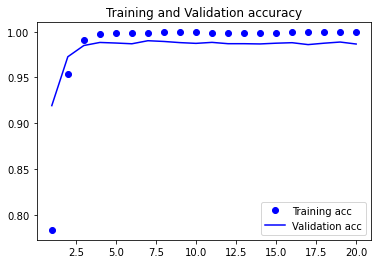

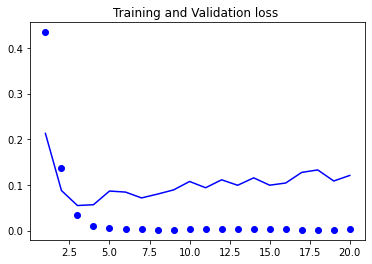

In [23]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss ')
plt.show()